In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from os import path
import glob

from src.utils import *
from src.forward_model import *

### Load in data

In [2]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Ground truth record path
gt_path = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/for_model_13/ground_truths')
gt_files = glob.glob(path.join(gt_path, '*'))

# Simulation output record path
record_dir = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/for_model_13/train')

# Output name prefix
sample_names = 'sample'

obj_dims = (648, 486)

In [3]:
# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

### Load in TFRecord data

In [4]:
# TFRecord Utils
feature_description = {
    'plane': tf.io.FixedLenFeature(obj_dims, tf.float32)
}
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def _create_example(plane, sim):
    plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
    sim_feature = tf.train.Feature(float_list=tf.train.FloatList(value=sim.ravel()))
    feature = {
        'plane': plane_feature,
        'sim': sim_feature
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

### Why's this so slow?
# def ravel_tf(x):
#     return tf.reshape(x, tf.math.reduce_prod(tf.shape(x)))

# def _create_example_tf(plane, sim):
#     plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=ravel_tf(plane)))
#     sim_feature = tf.train.Feature(float_list=tf.train.FloatList(value=ravel_tf(sim)))
#     feature = {
#         'plane': plane_feature,
#         'sim': sim_feature
#     }
#     return tf.train.Example(features=tf.train.Features(feature=feature))


In [5]:
raw_dataset = tf.data.TFRecordDataset(filenames=gt_files)
dataset = raw_dataset.map(_parse_function)

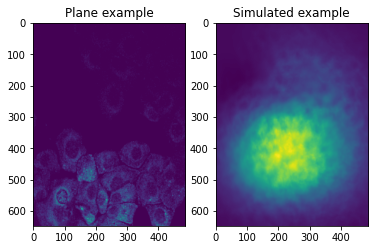

In [6]:
# Visualize a random example and its simulation under the forward model
dataset_iter = iter(dataset.shuffle(32))
plane_example = next(dataset_iter)['plane'].numpy()

model = ForwardModel()
sim_example = model.A_svd_2d(plane_example, weights, h)

fig = plt.figure()

ax1 = plt.subplot(121)
ax1.imshow(plane_example)
ax1.set_title("Plane example")

ax2 = plt.subplot(122)
ax2.imshow(sim_example)
ax2.set_title("Simulated example")

plt.show()

In [7]:
# psf = tf.math.reduce_sum(h*weights, axis=0)
# psf = psf / tf.math.reduce_max(psf)
# # plt.figure(figsize=(15,15))

In [8]:
# #using the central PSF to get the answer
# y2d = model.A_svd_2d_tf(plane_example, weights, h)
# plt.imshow(tf.squeeze(y2d))
# plt.show()

# # pad=pad2d
# y2d = tf.dtypes.cast(y2d, dtype=tf.complex64)
# psf = tf.dtypes.cast(psf, dtype=tf.complex64)

# Y=tf.signal.fft2d((pad_2d_tf(y2d[None, None, ...])))
# H_sum=tf.signal.fft2d((pad_2d_tf(psf[None, ...])))#np.sum(H,2)

# K=2000 #this variable can be learned, it has be greater than zero though

# X=(tf.math.conj(H_sum)*Y)/tf.dtypes.cast(tf.math.square(tf.math.abs(H_sum))+K, dtype=tf.complex64)
# x=tf.squeeze(tf.math.real((tf.signal.ifftshift(np.fft.ifft2(X), axes=(2, 3)))))

# x=crop_2d_tf(x)
# #x[x<0]=0
# plt.imshow(tf.squeeze(x))
# plt.colorbar()
# plt.show()




In [9]:
# K = 2000 #this variable can be learned, it has be greater than zero though
# x = model.wiener_deconvolve_one_step(y2d, psf, K)
# #x[x<0]=0
# plt.imshow(tf.squeeze(x))
# plt.colorbar()
# plt.show()


In [10]:
# from skimage import restoration

In [11]:
# sim_example = model.A_svd_2d_no_crop(plane_example, weights, h)

# fig = plt.figure()

# ax1 = plt.subplot(121)
# ax1.imshow(plane_example)
# ax1.set_title("Plane example")

# ax2 = plt.subplot(122)
# ax2.imshow(sim_example)
# ax2.set_title("Simulated example")

# plt.show()

In [12]:
# deconvolved = restoration.unsupervised_wiener(sim_example, h.squeeze())[0]

# plt.imshow(crop_2d(deconvolved) / weights.squeeze())
# plt.title("Wiener deconvolution result")

### Wiener Deconvolution Numpy

In [13]:
# Ah_b_2d = model.A_adj_svd_2d(sim_example, weights, h)

# def A2d_inv_cg(x, alpha_cg):
#     return model.A_adj_svd_2d(model.A_svd_2d(x, weights, h), weights, h) + alpha_cg*x

# def cgsolve(z, b, Niter, alpha_cg):
#     #b is A*y
#     #solving z=M-1b
#     r=b-A2d_inv_cg(z, alpha_cg)
#     p=r.copy()
#     rsold=np.conj(np.sum(r*r))
#     print('loss ', rsold)
#     for i in range(0,Niter):
#         Ap=A2d_inv_cg(p, alpha_cg)
#         alpha=rsold/(np.conj(np.sum(p*Ap)))
#         z=z+alpha*p
#         r=r-alpha*Ap
        
#         rsnew=np.conj(np.sum(r*r))
#         if np.sqrt(rsnew)<1e-10:
#             break
            
#         p=r+(rsnew/rsold)*p
#         rsold=rsnew
#         print('loss ',rsold)
#     return z

In [14]:
# Niter=20
# z_wiener=np.zeros(np.shape(sim_example))
# x_wiener=cgsolve(z_wiener,Ah_b_2d,Niter, 1e-4)

In [15]:
# plt.imshow(x_wiener)

### Wiener Deconvolution written in Tensorflow

In [16]:

# def A2d_inv_cg_tf(x, alpha_cg):
#     return model.A_adj_svd_2d_tf(model.A_svd_2d_tf(x, weights, h), weights, h) + alpha_cg*x

# def cgsolve_tf(z, b, Niter, alpha_cg):
#     #b is A*y
#     #solving z=M-1b
#     r=b-A2d_inv_cg_tf(z, alpha_cg)
#     p=tf.identity(r)
#     rsold=tf.math.conj(tf.math.reduce_sum(r*r))
# #     print('loss ', rsold)
#     for i in range(0,Niter):
#         Ap=A2d_inv_cg_tf(p, alpha_cg)
#         alpha=rsold/(tf.math.conj(tf.math.reduce_sum(p*Ap)))
#         z=z+alpha*p
#         r=r-alpha*Ap
        
#         rsnew=tf.math.conj(tf.math.reduce_sum(r*r))
#         if np.sqrt(rsnew)<1e-10:
#             break
            
#         p=r+(rsnew/rsold)*p
#         rsold=rsnew
# #         print('loss ',rsold)
#     return z

In [17]:
# import time

In [18]:
# Niter=20

## Running simulations with forward model

### Regular

In [19]:
# model = ForwardModel()

# for i, sample in enumerate(dataset):
#     plane = sample['plane'].numpy()
#     sim = model.A_svd_2d(plane, weights, h).astype(np.float16)

#     tf_example = _create_example(plane, sim)
#     record_file = path.join(record_dir, sample_names + '-sim-%.5d.tfrecord' % i)
    
#     with tf.io.TFRecordWriter(record_file) as writer:
#         writer.write(tf_example.SerializeToString())

#     if i % 500 == 0:
#         print('sim-%.5d processed' % i)

### With Wiener Deconvolution

In [20]:
# model = ForwardModel()

# for i, sample in enumerate(dataset):
#     plane = sample['plane']
#     sim = tf.dtypes.cast(model.A_svd_2d_tf(plane, weights, h), dtype=tf.float32)
    
#     # Wiener Deconvolution
#     Ah_b_2d = model.A_adj_svd_2d_tf(sim, weights, h)    
#     Niter=20
#     z_wiener=tf.zeros(tf.shape(sim))
#     x_wiener=cgsolve_tf(z_wiener,Ah_b_2d,Niter, 1e-4)

#     tf_example = _create_example(plane.numpy(), x_wiener.numpy())
#     record_file = path.join(record_dir, sample_names + '-sim-%.5d.tfrecord' % i)
    
#     with tf.io.TFRecordWriter(record_file) as writer:
#         writer.write(tf_example.SerializeToString())

#     if i % 500 == 0:
#         print('sim-%.5d processed' % i)

In [21]:
# model = ForwardModel()

# # Noise
# mu=0
# sigma=np.random.rand(len(gt_files))*0.04+0.01 #abit much maybe 0.04 best
# PEAK=np.random.rand(len(gt_files))*1000+50


# for i, sample in enumerate(dataset):
#     plane = sample['plane']
#     sim = tf.dtypes.cast(model.A_svd_2d_tf(plane, weights, h), dtype=tf.float32)
    
#     # Noise Generation
#     sim=sim/tf.math.reduce_max(sim)
#     sim=tf.nn.relu(sim)

#     p_noise = tf.squeeze(tf.random.poisson([1], sim * PEAK[i])) / PEAK[i]
#     g_noise= tf.random.normal([648, 486], mu, sigma[i])
#     sim=sim+g_noise+p_noise
#     sim=sim/tf.math.reduce_max(sim)
#     sim=tf.nn.relu(sim)
    
#     # Wiener Deconvolution
#     Ah_b_2d = model.A_adj_svd_2d_tf(sim, weights, h)    
#     Niter=20
#     z_wiener=tf.zeros(tf.shape(sim))
#     x_wiener=cgsolve_tf(z_wiener,Ah_b_2d,Niter, 1e-4)

#     tf_example = _create_example(plane.numpy(), x_wiener.numpy())
#     record_file = path.join(record_dir, sample_names + '-sim-%.5d.tfrecord' % i)
    
#     with tf.io.TFRecordWriter(record_file) as writer:
#         writer.write(tf_example.SerializeToString())

#     if i % 500 == 0:
#         print('sim-%.5d processed' % i)

## One step frequency Wiener Deconvolution

In [13]:
psf = tf.math.reduce_sum(h*weights, axis=0)
psf = psf / tf.math.reduce_max(psf)
K = 2000 #this variable can be learned, it has be greater than zero though


In [14]:
model = ForwardModel()

# Noise
mu=0
sigma=np.random.rand(len(gt_files))*0.04+0.01 #abit much maybe 0.04 best
PEAK=np.random.rand(len(gt_files))*1000+50


for i, sample in enumerate(dataset):
    plane = sample['plane']
    sim = tf.dtypes.cast(model.A_svd_2d_tf(plane, weights, h), dtype=tf.float32)
    
    # Noise Generation
    sim=sim/tf.math.reduce_max(sim)
    sim=tf.nn.relu(sim)

    p_noise = tf.squeeze(tf.random.poisson([1], sim * PEAK[i])) / PEAK[i]
    g_noise= tf.random.normal([648, 486], mu, sigma[i])
    sim=sim+g_noise+p_noise
    sim=sim/tf.math.reduce_max(sim)
    sim=tf.nn.relu(sim)
    
    # Wiener Deconvolution
    x = model.wiener_deconvolve_one_step(sim, psf, K)
    
    # Write to file
    tf_example = _create_example(plane.numpy(), x.numpy())
    record_file = path.join(record_dir, sample_names + '-sim-%.5d.tfrecord' % i)
    
    with tf.io.TFRecordWriter(record_file) as writer:
        writer.write(tf_example.SerializeToString())

    if i % 500 == 0:
        print('sim-%.5d processed' % i)

sim-00000 processed
sim-00500 processed
sim-01000 processed
sim-01500 processed
sim-02000 processed
sim-02500 processed
sim-03000 processed
sim-03500 processed
sim-04000 processed
sim-04500 processed
sim-05000 processed
sim-05500 processed
